# ACOUSTIC MONITORING OF ECOSYSTEMS

Ecosystems contain vast amounts of data that tell a lot about what is happening in them. Using acoustic monitoring we can monitor wildlife remotely and continously. Animals produce sounds that we can use to identify them without having to observe them physically. Birds, especially, vocalize a lot and we can use them in studying our ecosystems. In this notebook, we will see how we achieve acoustic classification of birds. We will classify three species of birds common in Kenya. The species are:
1. Hartlaub's turaco
2. Tropical boubou
3. Grey-backed camaroptera

We will use local audio data and data from [Xeno-canto](https://www.xeno-canto.org/) for this task. 



In [1]:
# import necessary libraries
import numpy as np
import librosa 
import os
import librosa.display
import IPython.display
import csv
import matplotlib.pyplot as plt
import warnings
import configparser
import random
from tqdm import tqdm
import soundfile as sf
from scipy.ndimage import binary_dilation, binary_erosion

In [2]:
warnings.filterwarnings('ignore')

# Get parameters from configuration file
config = configparser.ConfigParser()
config.read('files/parameters-birds.ini')

win_len_ms = int(config['audio']['win_len_ms'])
overlap = float(config['audio']['overlap'])
sampling_rate = int(config['audio']['sampling_rate'])
duration = float(config['neural-net']['input_duration_s'])
rnd_seed = int(config['neural-net']['seed'])
num_mels = int(config['baseline']['num_mels'])


# Derive audio processing values
win_len = int((win_len_ms * sampling_rate) / 1000)
hop_len = int(win_len * (1 - overlap))
nfft = int(2 ** np.ceil(np.log2(win_len)))
num_frame = int((0.5 * duration * sampling_rate) / hop_len)

Let's load and play 3 seconds of sample recordings for the three species:

In [37]:
# Hartlaub's turaco
y, _ = librosa.load('audio-samples/birds-sample/hartlaub\'s turaco.wav', sr=sampling_rate)
IPython.display.Audio(y[: int(sampling_rate * 3)], rate=sampling_rate)

In [39]:
# Tropical boubou
y, _ = librosa.load('audio-samples/birds-sample/tropical-boubou.wav', sr=sampling_rate)
IPython.display.Audio(y[: int(sampling_rate * 3)], rate=sampling_rate)

In [40]:
# Grey-backed camaropteraabs
y, _ = librosa.load('audio-samples/birds-sample/grey-backed camaroptera.wav', sr=sampling_rate)
IPython.display.Audio(y[: int(sampling_rate * 3)], rate=sampling_rate)

The samples sound differently to our ears. Anyone with the experience of telling the three species from their sounds can easily identify them from listening to the samples we have just played. We intend to enable a digital computer to mimick this behaviour and identify different bird species from their sounds. This will be achieved using digital signal processing and machine learning.

## Acoustic Classification of Birds
Acoustic classification of birds is an interesting field that can find its use in ecosystems conservation, ornithology and also for bird watchers. Manual classification of acoustic data is cumbersome and so we opt for automatic acoustic classification. Automatic acoustic classification of birds is, however, faced by the following challenges:
1. Limited annotated data per species
2. Background noise
3. Variable length of recordings
4. Multiple birds singing simultaneously
To achieve reasonble results, we need to manipulate the data. This is acheived using data preprocessing and data augmentation.

### Data preprocessing
In this task, we separated audio files into signal into signal part where bird sounds are audible and noise part where there are no bird sounds (background noise may be present in this part). The separation of the audio file into signal and noise parts is done as described in **Sprengel, E., Jaggi, M., Kilcher, Y., & Hofmann, T. (2016). Audio based bird species identification using deep learning techniques**.

#### Signal extraction
This acheived by computing the spectrogram of an audio file and then selecting pixels that have a value greater than a given threshold and treating them as corresponding to signal.
#### Noise extraction
This was acheived by selecting the pixel values of the spectrogram that are less than a given threshold and treating them as corresponding to noise.

Let's load a sample audio file at a sampling rate of 16kHz and split it into signal and noise parts.

In [6]:
path = './audio-samples/birds-sample/grey-backed camaroptera.mp3'
y, _ = librosa.load(path, sr=sampling_rate)
IPython.display.Audio(y, rate=sampling_rate)

Let's compute and normalize the spectrogram of the loaded file. The spectrogram is obtaining by performing Fast Fourier Transform (FFT) on the audio with a Hamming window of size 40ms and an overlap of 75%. 

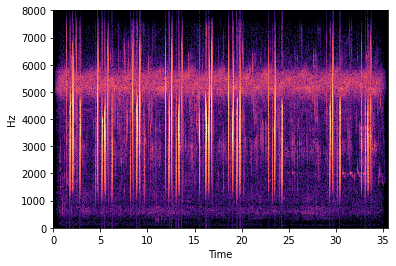

In [7]:
specgram = np.abs(librosa.stft(y,
                              n_fft=nfft,
                              win_length=win_len,
                              hop_length=hop_len,
                              window='hamming'))

normalized_specgram = specgram / np.max(specgram)

librosa.display.specshow(librosa.amplitude_to_db(normalized_specgram, ref=np.max),
                        sr=sampling_rate,
                        hop_length=hop_len,
                        y_axis='linear',
                        x_axis='time')

### 1. Signal extraction

#### i. Selecting pixels corresponding to signal
We will begin by selecting pixels of normalized spectrogram that are that are 3 times greater than the row and column median and set them all to 1 and the rest to zero.

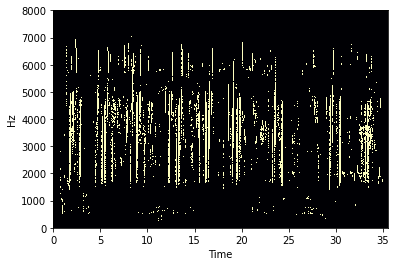

In [8]:
#select segments containing audio and plot the spectrogram
threshold = 3
col_mask = specgram > threshold * np.median(specgram, axis=0) #elements of spectrogram greater than 3*median of column
row_mask = specgram.T > threshold * np.median(specgram, axis=1) #elements of spectrogram greater than 3*median of row
row_mask  = row_mask.T
mask = col_mask & row_mask

mask = mask.astype(int)
librosa.display.specshow(librosa.amplitude_to_db(mask, ref=np.max),
                         sr=sampling_rate,
                         hop_length=hop_len,
                         y_axis='linear', 
                         x_axis='time')

#### ii. Binary erosion
Let's apply a 4 by 4 binary erosion filter to the masked spectrogram to remove noise and visualize the output of the filter.

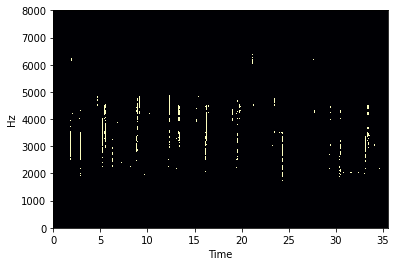

In [9]:
# erosion
audio_be_mask = binary_erosion(mask, np.ones((4, 4)))
audio_be_mask
audio_be_mask = audio_be_mask.astype(int)
librosa.display.specshow(librosa.amplitude_to_db(audio_be_mask, ref=np.max),
                         sr=sampling_rate,
                         hop_length=hop_len,
                         y_axis='linear', 
                         x_axis='time')

#### iii. Binary dilation
Let's now apply a 4 by 4 binary dilation filter to the spectrogram obtained above to smoothen it visualize the output of the filter.

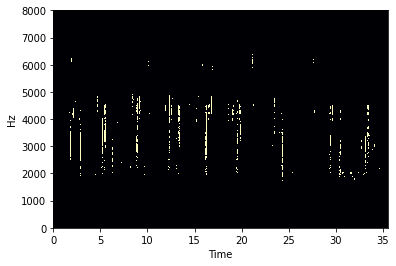

In [10]:
# dilation
audio_bd_be_mask = binary_dilation(audio_be_mask, np.ones((2, 2)))
audio_bd_be_mask = audio_bd_be_mask.astype(int)
librosa.display.specshow(librosa.amplitude_to_db(audio_bd_be_mask, ref=np.max),
                         sr=sampling_rate,
                         hop_length=hop_len,
                         y_axis='linear', 
                         x_axis='time')

#### iv. Indicator vector
We will generate an indicator vector of the same length as the number of columns of the spectrogram. Each column of the spectrogram represent a window that the audio file was split into to perform short time fourier transform (STFT). The indicator vector is created by making its i-th element to 1 if there is at least one 1 in the i-th column and 0 otherwise. We then smoothen the vector by applying two 4 by 1 dilation filters.

In [11]:
selected_col = np.max(audio_bd_be_mask, axis=0)
bd_sel_col = binary_dilation(selected_col[:, None], np.ones((4, 1)))
bd2_sel_col = binary_dilation(bd_sel_col, np.ones((4, 1)))

#### v. Signal mask
The indicator vector obtained above is scaled to the length of the audio file and used to extract parts of the audio that correspond to a signal

In [12]:
# translate to audio samples
selection_mtx = np.ones((specgram.shape[1], hop_len)) * bd2_sel_col

audio_indx = selection_mtx.flatten().astype(bool)
selection_mtx.shape

audio_indx = selection_mtx.flatten().astype(bool)

signal = y[audio_indx[:len(y)]]
IPython.display.Audio(signal, rate=sampling_rate)

sf.write('audio-samples/birds-sample/signal.wav', signal, sampling_rate)

#### vi. Visualizing the extracted signal

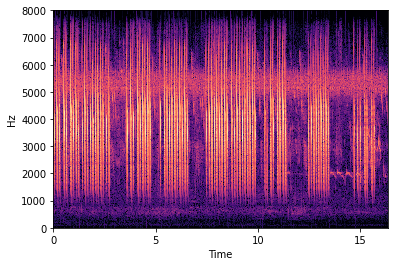

In [13]:
S_audio = np.abs(librosa.stft(signal, 
                        n_fft=nfft, 
                        hop_length=hop_len))
librosa.display.specshow(librosa.amplitude_to_db(S_audio, ref=np.max),
                         sr=sampling_rate,
                         hop_length=hop_len,
                         y_axis='linear', 
                         x_axis='time')

### 2. Noise extraction
In the sections that follow, we will repeat the steps followed in signal extraction, however, we will set the threshold for selecting pixels at 2.5 time greater than row and column median.
#### i. Selecting pixels 2.5 time greater than row and column median.

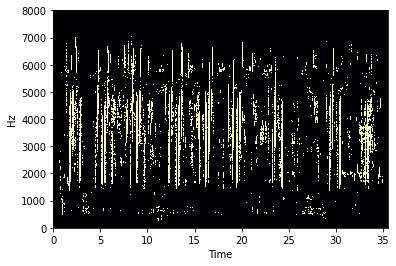

In [14]:
threshold = 2.5
col_mask = specgram > threshold * np.median(specgram, axis=0) #elements of spectrogram greater the 3*median of column
row_mask = specgram.T > threshold * np.median(specgram, axis=1) #elements of spectrogram greater the 3*median of row
row_mask  = row_mask.T
mask = col_mask & row_mask

mask = mask.astype(int)
librosa.display.specshow(librosa.amplitude_to_db(mask, ref=np.max),
                         sr=sampling_rate,
                         hop_length=hop_len,
                         y_axis='linear', 
                         x_axis='time')

#### ii. Binary erosion

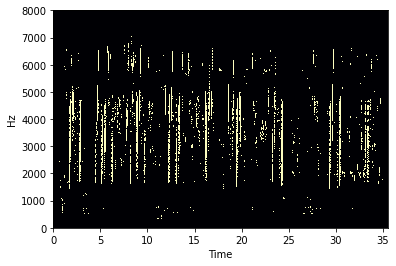

In [15]:
# erosion
noise_be_mask = binary_erosion(mask, np.ones((2, 2)))
noise_be_mask
noise_be_mask = noise_be_mask.astype(int)
librosa.display.specshow(librosa.amplitude_to_db(noise_be_mask, ref=np.max),
                         sr=sampling_rate,
                         hop_length=hop_len,
                         y_axis='linear', 
                         x_axis='time')

#### iii. Binary dilation

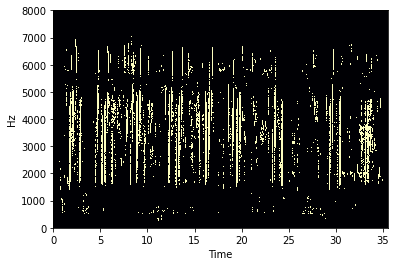

In [16]:
# dilation
noise_bd_be_mask = binary_dilation(noise_be_mask, np.ones((2, 2)))
noise_bd_be_mask = noise_bd_be_mask.astype(int)
librosa.display.specshow(librosa.amplitude_to_db(noise_bd_be_mask, ref=np.max),
                         sr=sampling_rate,
                         hop_length=hop_len,
                         y_axis='linear', 
                         x_axis='time')

#### iv. Indicator vector

In [17]:
selected_col = np.max(audio_bd_be_mask, axis=0)
bd_sel_col = binary_dilation(selected_col[:, None], np.ones((4, 1)))
bd2_sel_col = binary_dilation(bd_sel_col, np.ones((4, 1)))

#### v. Indicator mask
The indicator vector obtained above is scaled to the length of the audio file, inverted and used to extract parts of the audio that correspond to noise.

In [18]:
# translate to audio samples
selection_mtx = np.ones((specgram.shape[1], hop_len)) * bd2_sel_col

audio_indx = selection_mtx.flatten().astype(bool)
selection_mtx.shape

audio_indx = selection_mtx.flatten().astype(bool)

audio_indx = ~audio_indx

noise = y[audio_indx[:len(y)]]
IPython.display.Audio(noise, rate=sampling_rate)

sf.write('audio-samples/birds-sample/noise.wav', noise, sampling_rate)

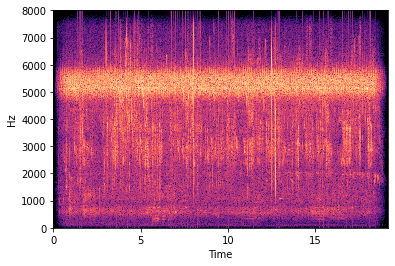

In [19]:
S_noise = np.abs(librosa.stft(noise, 
                        n_fft=nfft, 
                        hop_length=hop_len))
librosa.display.specshow(librosa.amplitude_to_db(S_noise, ref=np.max),
                         sr=sampling_rate,
                         hop_length=hop_len,
                         y_axis='linear', 
                         x_axis='time')

The above steps will be carried out on the entire dataset and signal and noise files saved

## Features Extraction

We will extract features from the recordings and use them as inputs to our machine learning models. We will use melspectrograms for this task. The melspectrograms are obtained by applying 40 mel filters to the spectrograms of the recordings. 

Let's compute the melspectrograms of the recordings of the three species we played at the beginning of this notebook:

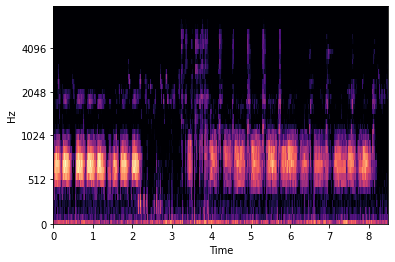

In [20]:
#Hartlaub's turaco

y, _ = librosa.load('audio-samples/birds-sample/hartlaub\'s turaco.wav', sr=sampling_rate)



melspect = librosa.feature.melspectrogram(y,
                                        sr=sampling_rate,
                                        n_fft=nfft,
                                        hop_length=hop_len,
                                        win_length=win_len,
                                        window='hamming',
                                        n_mels=num_mels)

if not os.path.exists('melspects'):
    os.mkdir('melspects')

np.save('melspects/hartlaub\'s.npy', melspect)

#melspect_db = librosa.power_to_db(melspect, ref=np.max)

librosa.display.specshow(librosa.amplitude_to_db(melspect, ref=np.max),
                        hop_length=hop_len,
                        sr=sampling_rate,
                        y_axis='mel',
                        x_axis='time')

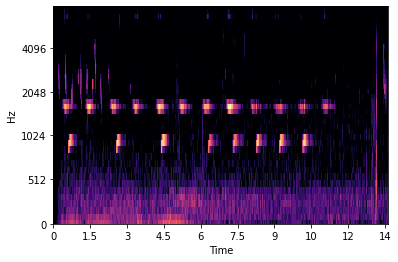

In [21]:
#tropicalboubou

y, _ = librosa.load('audio-samples/birds-sample/tropical-boubou.wav', sr=sampling_rate)



melspect = librosa.feature.melspectrogram(y,
                                        sr=sampling_rate,
                                        n_fft=nfft,
                                        hop_length=hop_len,
                                        win_length=win_len,
                                        window='hamming',
                                        n_mels=num_mels)
np.save('melspects/tropical.npy', melspect)

#melspect_db = librosa.power_to_db(melspect, ref=np.max)

librosa.display.specshow(librosa.amplitude_to_db(melspect, ref=np.max),
                        hop_length=hop_len,
                        sr=sampling_rate,
                        y_axis='mel',
                        x_axis='time')


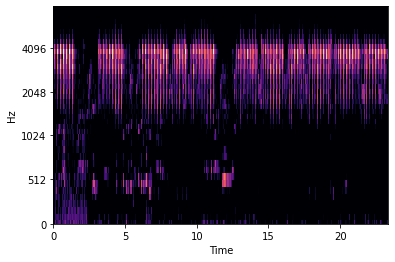

In [22]:
#grey-backed camaroptera

y, _ = librosa.load('audio-samples/birds-sample/grey-backed camaroptera.wav', sr=sampling_rate)



melspect = librosa.feature.melspectrogram(y,
                                        sr=sampling_rate,
                                        n_fft=nfft,
                                        hop_length=hop_len,
                                        win_length=win_len,
                                        window='hamming',
                                        n_mels=num_mels)

np.save('melspects/grey-backed.npy', melspect)

#melspect_db = librosa.power_to_db(melspect, ref=np.max)

librosa.display.specshow(librosa.amplitude_to_db(melspect, ref=np.max),
                        hop_length=hop_len,
                        sr=sampling_rate,
                        y_axis='mel',
                        x_axis='time')

We can visually observe that the melspectrograms of the three species are different. This is because of difference in frequency components of sounds of birds belonging to different species.  We will be using this uniqueness to identify different species of birds from their sound.

### Audio padding
For our classification models, we need fixed size inputs. However, before and after signal and noise separation, some files have shorter lengths than the required threshold length. To ensure these files are of at least threshold-length long, we will pad them with noise. Padding a signal with noise helps in developing the model by exposing it to the noise it will encounter in the field. 

Let's load a signal file and plot its spectrogram.

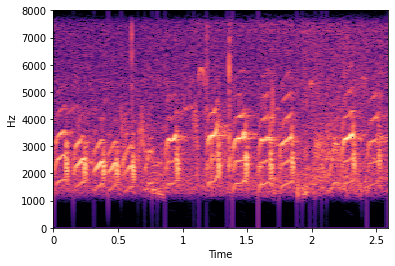

In [23]:
signal, _ = librosa.load('./audio-samples/birds-sample/short-recording.wav', sr=sampling_rate)

specgram = np.abs(librosa.stft(signal, 
                        n_fft=nfft, 
                        hop_length=hop_len))
librosa.display.specshow(librosa.amplitude_to_db(specgram, ref=np.max),
                         sr=sampling_rate,
                         hop_length=hop_len,
                         y_axis='linear', 
                         x_axis='time')

Now, let's pad it with noise to ensure it is at least 3 seconds long and visualize it

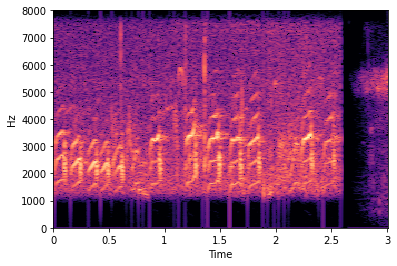

In [24]:
duration = 3

if (len(signal) / sampling_rate) < duration:
    noise, _ = librosa.load('./audio-samples/birds-sample/noise.wav', sr=sampling_rate)
    while (len(signal) / sampling_rate) < duration:
        signal = np.concatenate((signal,noise))
        
signal = signal[:int(duration * sampling_rate) + 1]

specgram = np.abs(librosa.stft(signal, 
                        n_fft=nfft, 
                        hop_length=hop_len))
librosa.display.specshow(librosa.amplitude_to_db(specgram, ref=np.max),
                         sr=sampling_rate,
                         hop_length=hop_len,
                         y_axis='linear', 
                         x_axis='time')

The above steps of padding and features extraction were performed on the audio files obtained after signal noise separation and the features saved as numpy arrays.

### Features Generation

The features that were fed to machine learning models are the mean and the variance of the frequency channels. We split the melspectrograms into chunks of equal length. Therefore, from one audio data, we obtain multiple features that we feed to machine learning models. This helps solve the problem of limited data per species and that of variable length of recordings. We will use image standardization for scaling the melspectrograms. 

Let's load the melspectrograms of the three species and perform these operations: 

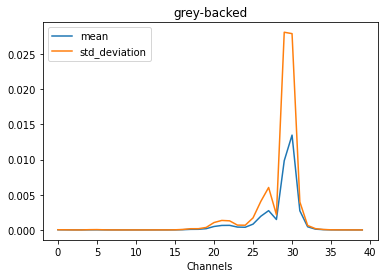

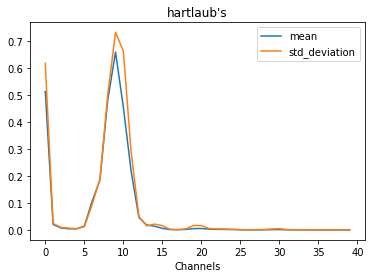

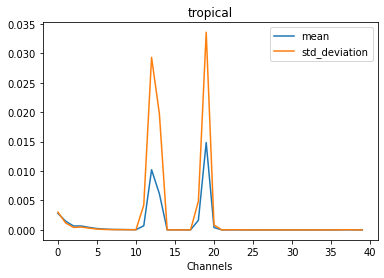

In [36]:
files = [file for file in os.listdir('./melspects') if file.endswith('.npy')]



for file in files:
    melspect = np.load(os.path.join('melspects', file))
    if melspect.shape[1] > 2 * num_frame + 1: #process audio block of length 3 seconds
        indx = random.randint(num_frame, melspect.shape[1] - num_frame - 1)
        current_feature = melspect[:, indx - num_frame: indx + num_frame + 1]
        plt.figure()
        plt.plot(np.mean(current_feature, axis=1), label='mean')
        plt.plot(np.std(current_feature, axis=1),  label='std_deviation')
        plt.xlabel('Channels')
        plt.title(file.split('.')[0])
        plt.legend()

## Baseline Models
A baseline model can be defined as a simple model that provides reasonable results on a task and requires not much time and expertise to develop. Baseline models helps put the more complex models into context in terms of accuracy. The results obtained from a baseline model should guide us in making the choice of complex model to use. In this classification task, we will use `Linear Support Vector Classifier`, `Support Vector Classifier`, `Multilayer Perceptron Classifier` and `Random Forests Classifiers` as our baseline models.

In [26]:
#import necessary libraries
import pickle
import tensorflow as tf
from keras import layers
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import features_generation as fg
import preprocessing_functions as pf

In [27]:
#load a pretrained model and use it to predict a sample test data
tree = next(os.walk('audio-samples/birds-test-data/'))

dir_paths = [os.path.join(tree[0], sub_dir) for sub_dir in tree[1]]

filelist = []
for sub_dir in dir_paths:
    files = os.listdir(sub_dir)
    for file in files:
        filelist.append(os.path.join(sub_dir, file).replace('\\', '/'))
        
file_indx = random.randint(0, len(filelist) - 1)
file = filelist[file_indx]

target = file.split('/')[2]

clf = pickle.load(open(os.path.join('models', 'rf64bit.pickle'), 'rb'))

audio,_ = librosa.load(file, sr=sampling_rate)
feature = fg.features_extraction(audio,
                             nfft,
                             hop_len,
                             'audio-samples/noise',
                             sampling_rate,
                             duration,
                             win_len,
                             hop_len,
                             num_mels)

fmean = np.load('./files/fmean-birds.npy')
fstd = np.load('./files/fstd-birds.npy')
X = pf.all_summary_features(feature, num_frame, fmean, fstd)

species  = ['grey-backed camaroptera', 'hartlaub\'s turaco', 'tropical boubou']

predicted = clf.predict(X)

indx = random.randint(0, len(predicted) - 1)

predicted = species[int(predicted[indx])]

print('Predicted species:',  predicted, '\n', 'Expected species:', target)

Predicted species: hartlaub's turaco 
 Expected species: hartlaub's turaco
